In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, Callback, ReduceLROnPlateau
from keras.layers.noise import AlphaDropout
import keras.activations
import numpy as np
import pandas as pd
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, HTML


C:\Users\MaksutovRN\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


X values are just linear sequence

In [2]:
x_train = np.linspace(0., 0.099, 100)
x_test = np.linspace(0.1, 0.109, 10)

print(x_train)
print(x_test)

[0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011
 0.012 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023
 0.024 0.025 0.026 0.027 0.028 0.029 0.03  0.031 0.032 0.033 0.034 0.035
 0.036 0.037 0.038 0.039 0.04  0.041 0.042 0.043 0.044 0.045 0.046 0.047
 0.048 0.049 0.05  0.051 0.052 0.053 0.054 0.055 0.056 0.057 0.058 0.059
 0.06  0.061 0.062 0.063 0.064 0.065 0.066 0.067 0.068 0.069 0.07  0.071
 0.072 0.073 0.074 0.075 0.076 0.077 0.078 0.079 0.08  0.081 0.082 0.083
 0.084 0.085 0.086 0.087 0.088 0.089 0.09  0.091 0.092 0.093 0.094 0.095
 0.096 0.097 0.098 0.099]
[0.1   0.101 0.102 0.103 0.104 0.105 0.106 0.107 0.108 0.109]


Our simple function that we want our neural network to learn

In [3]:
def func(x, a, b):
    return a * x + b

We want the network to find those 0.1 weight for kernel and 0.3 for bias

In [4]:
y_train = func(x_train, 0.1, 0.3)
y_test = func(x_test, 0.1, 0.3)

print(y_train)
print(y_test)

[0.3    0.3001 0.3002 0.3003 0.3004 0.3005 0.3006 0.3007 0.3008 0.3009
 0.301  0.3011 0.3012 0.3013 0.3014 0.3015 0.3016 0.3017 0.3018 0.3019
 0.302  0.3021 0.3022 0.3023 0.3024 0.3025 0.3026 0.3027 0.3028 0.3029
 0.303  0.3031 0.3032 0.3033 0.3034 0.3035 0.3036 0.3037 0.3038 0.3039
 0.304  0.3041 0.3042 0.3043 0.3044 0.3045 0.3046 0.3047 0.3048 0.3049
 0.305  0.3051 0.3052 0.3053 0.3054 0.3055 0.3056 0.3057 0.3058 0.3059
 0.306  0.3061 0.3062 0.3063 0.3064 0.3065 0.3066 0.3067 0.3068 0.3069
 0.307  0.3071 0.3072 0.3073 0.3074 0.3075 0.3076 0.3077 0.3078 0.3079
 0.308  0.3081 0.3082 0.3083 0.3084 0.3085 0.3086 0.3087 0.3088 0.3089
 0.309  0.3091 0.3092 0.3093 0.3094 0.3095 0.3096 0.3097 0.3098 0.3099]
[0.31   0.3101 0.3102 0.3103 0.3104 0.3105 0.3106 0.3107 0.3108 0.3109]


One of the ways we will be evaluating the progress of the network with each optimizer configuration is to let them to start from the same point (1., 0.) and then move towards the (0.1, 0.3) point. In order to visualize this first point we need to find the starting Mean Squared Error value for those initial weights.

In [5]:
base_error = np.mean(np.square(func(x_train, 1., 0.) - func(x_train, 0.1, 0.3)), axis=-1)
base_error

0.065929635

Common hyperparameters

In [22]:
batch_size = 10
epochs = 200
units = 1

# Here we will store our training histories
histories = {}

This custom callback will help us to record the weights on each epoch so we then can visualize the path of the optimizer

In [7]:
class RecordOutputsWeights(Callback):

    def __init__(self, w_holder):
        super(Callback, self).__init__()
        self.w_holder = w_holder
    
    def on_train_begin(self, logs=None):
        layers = self.model.layers
        for layer in layers:
            weights = layer.get_weights() 
            if len(weights) > 0:
                config = layer.get_config()
                self.w_holder.append([weights[0][0][0], weights[1][0]])
                
    def on_epoch_end(self, epoch, logs=None):
        layers = self.model.layers
        for layer in layers:
            weights = layer.get_weights() 

            if len(weights) > 0:
#                 weights = np.array(weights[1])
                config = layer.get_config()
                
                self.w_holder.append([weights[0][0][0], weights[1][0]])
                

`train` function builds the model and performs training. It accepts the list of optimizer configurations, the name of the optimizer and the type of initialization for the Dense layer. Returns the list of training history objects, which can be passed to `plot_training` function.

In [41]:
def train(configs, optimizer, initializer = 'default'):
    tr_hist = []
    
    for cfg in configs:
        print("Training config %s" % str(cfg))
        w_holder = []
        K.clear_session()
        K.reset_uids()
        model = Sequential()
        
        if initializer == 'default':
            model.add(Dense(units, input_dim=1, activation='linear', name = 'input'))
        else:
            model.add(Dense(units, input_dim=1, kernel_initializer = initializer, activation='linear', name = 'input'))
        
        if optimizer == 'rmsp':    
            opt = keras.optimizers.rmsprop(lr=cfg['lr'], rho = cfg['rho'])
        elif optimizer == 'sgd':
            opt = keras.optimizers.SGD(lr=cfg['lr'], momentum=cfg['momentum'], nesterov=cfg['nesterov'])
        elif optimizer == 'Adamax':
            opt = keras.optimizers.Adamax(lr=cfg['lr'], beta_1=cfg['beta_1'], beta_2=cfg['beta_2'])

        model.compile(optimizer=opt, loss='mse')
        
        recorder = RecordOutputsWeights(w_holder)
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0,
                            shuffle=True,
                            validation_data=(x_test, y_test),
                            callbacks=[recorder])

        preds = model.predict([0., 1.])
        print ('Prediction for 0.: %0.4f, should be 0.3' % preds[0][0])
        print ('Prediction for 0.1: %0.4f, should be 0.4' % preds[1][0])
        print ('MSE: ' + str(history.history['loss'][-1]) + '\n')

        w_a = []
        w_b = []
        for w in w_holder:
            w_a.append(w[0])
            w_b.append(w[1])

        losses = history.history['loss']
        losses.insert(0, base_error)
        tr_hist.append({
            'w_a': w_a,
            'w_b': w_b,
            'loss': losses,
            'pred_0':preds[0][0],
            'pred_01': preds[1][0],
            'optimizer': optimizer,
            'label': str(cfg['lr'])
        })
    print('-'*30)
    return tr_hist

`plot_training` function accepts the object with our training history and some other supplementarty info and plots 2 3D graphs of the MSE on each epoch with respect to relevant kernel and bias weights. The plots visualize the same MSE from 4 different angles, so that you are able to see the differences in the paths.

In [29]:
def plot_training(training_history, title):
    
    # Let's first sort the training history objects so that the models with lower final MSE are at the top of the list
    # This way they will be drawn first, and will not overlap the models, which follow the same path, but have stopped
    # improving earlier.
    training_history = sorted(training_history, key=lambda k: k['loss'][-1]) 
    
    fig = plt.figure(figsize=(8,8))
    fig.suptitle(title, fontsize = 16)
    
    ax = fig.add_subplot(1,1,1, projection='3d')
    i=1
    for t_h in training_history:
        cols = np.linspace(0., 1., len(t_h['loss'])) 
        ax.plot(t_h['w_a'], t_h['w_b'], t_h['loss'], marker = ".", label = '%d: %s' % (i, t_h['label']))
        i+=1
        
    ax.scatter([0.1], [0.3], [0.], marker = 'o', label = 'Global minima', color = 'k', s = 300)
    ax.view_init(30, 120)
    ax.legend()
    plt.xlabel('Kernel')
    plt.ylabel('Bias')
    
    
    
    plt.show()
    
    stats = pd.DataFrame(columns = ['Configuration', 'a', 'b', 'Prediction for 0.0', 'Prediction for 1.0', 'Final MSE'])
    
    for i in range(len(training_history)):
        stats.loc[i] = [
            training_history[i]['label'],
            training_history[i]['w_a'][-1],
            training_history[i]['w_b'][-1],
            training_history[i]['pred_0'],
            training_history[i]['pred_01'],
            training_history[i]['loss'][-1]
        ]
    display(stats)

# SGD
## Momentum

In [50]:
configs = [
    
    {'momentum': 0.0, 'nesterov': False, 'lr': 0.99 },
    {'momentum': 0.0, 'nesterov': False, 'lr': 0.9 },
    {'momentum': 0.0, 'nesterov': False, 'lr': 0.5 },
    {'momentum': 0.0, 'nesterov': False, 'lr': 0.1 },
    {'momentum': 0.0, 'nesterov': False, 'lr': 0.01 },
]

histories['SGD. Learning rates'] = train(configs, 'sgd', 'ones')

Training config {'momentum': 0.0, 'nesterov': False, 'lr': 0.99}
Prediction for 0.: 0.2977, should be 0.3
Prediction for 0.1: 0.4329, should be 0.4
MSE: 2.946268136838626e-06

Training config {'momentum': 0.0, 'nesterov': False, 'lr': 0.9}
Prediction for 0.: 0.2979, should be 0.3
Prediction for 0.1: 0.4425, should be 0.4
MSE: 1.8246029753754556e-06

Training config {'momentum': 0.0, 'nesterov': False, 'lr': 0.5}
Prediction for 0.: 0.2915, should be 0.3
Prediction for 0.1: 0.5636, should be 0.4
MSE: 2.5993883900810034e-05

Training config {'momentum': 0.0, 'nesterov': False, 'lr': 0.1}
Prediction for 0.: 0.2669, should be 0.3
Prediction for 0.1: 1.0204, should be 0.4
MSE: 0.00035976986691821367

Training config {'momentum': 0.0, 'nesterov': False, 'lr': 0.01}
Prediction for 0.: 0.2563, should be 0.3
Prediction for 0.1: 1.2390, should be 0.4
MSE: 0.000650473462883383

------------------------------


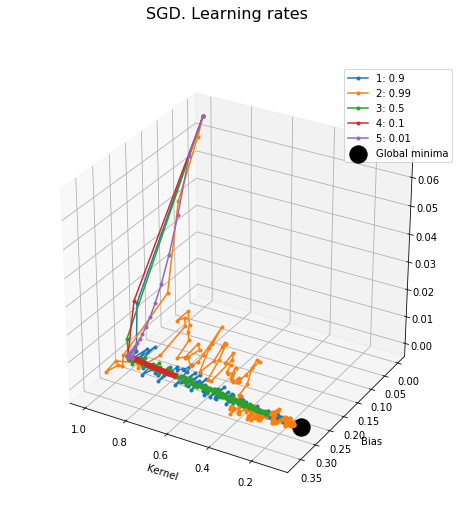

,Configuration,a,b,Prediction for 0.0,Prediction for 1.0,Final MSE
0,0.9,0.144626,0.297867,0.297867,0.442493,0.000002
1,0.99,0.135232,0.297684,0.297684,0.432916,0.000003
2,0.5,0.272176,0.291453,0.291453,0.563629,0.000026
3,0.1,0.753484,0.266946,0.266946,1.020430,0.000360
4,0.01,0.982736,0.256304,0.256304,1.239040,0.000650


In [51]:
plot_training(histories['SGD. Learning rates'], 'SGD. Learning rates')

# RMSProp
## Learning rate

In [48]:
configs = [
    {'rho': 0.9, 'lr': 0.2 },
    {'rho': 0.9, 'lr': 0.1 },
    {'rho': 0.9, 'lr': 0.05 },
    {'rho': 0.9, 'lr': 0.01 },
    {'rho': 0.9, 'lr': 0.001 },
]

histories['RMSProp. Learning rate.'] = train(configs, 'rmsp', 'ones')

Training config {'rho': 0.9, 'lr': 0.2}
Prediction for 0.: 0.1862, should be 0.3
Prediction for 0.1: 0.2077, should be 0.4
MSE: 0.010335119720548392

Training config {'rho': 0.9, 'lr': 0.1}
Prediction for 0.: 0.2503, should be 0.3
Prediction for 0.1: 0.2691, should be 0.4
MSE: 0.0027465209597721694

Training config {'rho': 0.9, 'lr': 0.05}
Prediction for 0.: 0.3202, should be 0.3
Prediction for 0.1: 0.4871, should be 0.4
MSE: 0.0007023532874882221

Training config {'rho': 0.9, 'lr': 0.01}
Prediction for 0.: 0.2947, should be 0.3
Prediction for 0.1: 0.3866, should be 0.4
MSE: 2.6021209669124802e-05

Training config {'rho': 0.9, 'lr': 0.001}
Prediction for 0.: 0.2995, should be 0.3
Prediction for 0.1: 0.3991, should be 0.4
MSE: 2.6130073251806605e-07

------------------------------


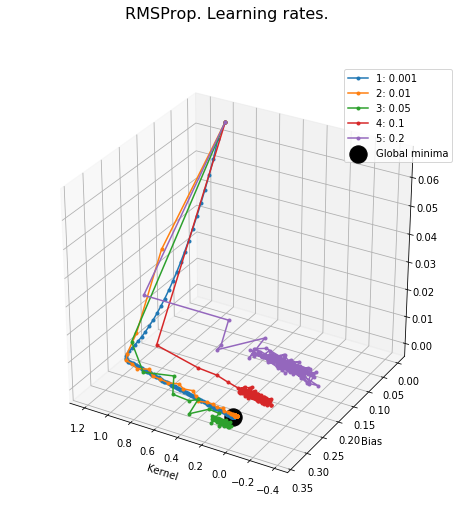

,Configuration,a,b,Prediction for 0.0,Prediction for 1.0,Final MSE
0,0.001,0.099573,0.299502,0.299502,0.399075,2.613007e-07
1,0.01,0.091942,0.294662,0.294662,0.386604,2.602121e-05
2,0.05,0.166876,0.320212,0.320212,0.487088,7.023533e-04
3,0.1,0.018844,0.250271,0.250271,0.269115,2.746521e-03
4,0.2,0.021481,0.186192,0.186192,0.207673,1.033512e-02


In [49]:
plot_training(histories['RMSProp. Learning rate.'], 'RMSProp. Learning rates.')

# AdaMax
## Learning Rates

In [25]:
configs = [
    {'lr': 0.002, 'beta_1': 0.9, 'beta_2': 0.999 },
    {'lr': 0.01, 'beta_1': 0.9, 'beta_2': 0.999 },
    {'lr': 0.05, 'beta_1': 0.9, 'beta_2': 0.999 },
    {'lr': 0.1, 'beta_1': 0.9, 'beta_2': 0.999 },
    {'lr': 0.5, 'beta_1': 0.9, 'beta_2': 0.999 },
    {'lr': 0.9, 'beta_1': 0.9, 'beta_2': 0.999 },
]

histories['AdaMax. Learning rates'] = train(configs, 'Adamax', 'ones')

Training config {'lr': 0.002, 'beta_1': 0.9, 'beta_2': 0.999}
Prediction for 0.: 0.2717, should be 0.3
Prediction for 0.1: 0.9312, should be 0.4
MSE: 0.0002639243466546759

Training config {'lr': 0.01, 'beta_1': 0.9, 'beta_2': 0.999}
Prediction for 0.: 0.2986, should be 0.3
Prediction for 0.1: 0.4258, should be 0.4
MSE: 6.523901419086542e-07

Training config {'lr': 0.05, 'beta_1': 0.9, 'beta_2': 0.999}
Prediction for 0.: 0.3000, should be 0.3
Prediction for 0.1: 0.4000, should be 0.4
MSE: 2.398081788776875e-16

Training config {'lr': 0.1, 'beta_1': 0.9, 'beta_2': 0.999}
Prediction for 0.: 0.3000, should be 0.3
Prediction for 0.1: 0.4000, should be 0.4
MSE: 1.5099033558418602e-16

Training config {'lr': 0.5, 'beta_1': 0.9, 'beta_2': 0.999}
Prediction for 0.: 0.3000, should be 0.3
Prediction for 0.1: 0.4000, should be 0.4
MSE: 7.63833445706668e-16

Training config {'lr': 0.9, 'beta_1': 0.9, 'beta_2': 0.999}
Prediction for 0.: 0.3000, should be 0.3
Prediction for 0.1: 0.4000, should be 0.

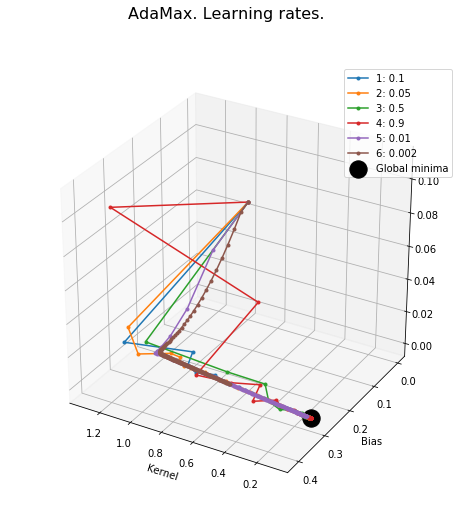

,Configuration,a,b,Prediction for 0.0,Prediction for 1.0,Final MSE
0,0.1,0.100000,0.300000,0.300000,0.400000,1.509903e-16
1,0.05,0.100000,0.300000,0.300000,0.400000,2.398082e-16
2,0.5,0.100000,0.300000,0.300000,0.400000,7.638334e-16
3,0.9,0.100000,0.300000,0.300000,0.400000,1.270095e-15
4,0.01,0.127139,0.298617,0.298617,0.425756,6.523901e-07
5,0.002,0.659514,0.271729,0.271729,0.931243,2.639243e-04


In [31]:
plot_training(histories['AdaMax. Learning rates'], 'AdaMax. Learning rates.')

In [115]:
ranking = pd.DataFrame(columns = ['Optimizer', 'Configuration', 'a', 'b', 'Prediction for 0.0', 'Prediction for 1.0', 'Final MSE'])

for key, value in histories.items():
    for i in range(len(value)):
        ranking = ranking.append({
            'Optimizer': value[i]['optimizer'],
            'Configuration': value[i]['label'],
            'a': value[i]['w_a'][-1],
            'b': value[i]['w_b'][-1],
            'Prediction for 0.0': value[i]['pred_0'],
            'Prediction for 1.0': value[i]['pred_01'],
            'Final MSE': value[i]['loss'][-1]
        }, ignore_index=True)

ranking = ranking.sort_values(by=['Final MSE'])        
ranking

,Optimizer,Configuration,a,b,Prediction for 0.0,Prediction for 1.0,Final MSE
67,adam,"amsgrad: False, lr: 0.1, beta_1: 0.95, beta_2:...",0.100000,0.300000,0.300000,0.400000,1.243450e-16
41,rmsp,"rho: 0.9999, lr: 0.01",0.100000,0.300000,0.300000,0.400000,2.309264e-16
81,adam,"amsgrad: True, lr: 0.1, beta_1: 0.9, beta_2: 0.95",0.100000,0.300000,0.300000,0.400000,2.398082e-16
82,adam,"amsgrad: True, lr: 0.1, beta_1: 0.9, beta_2: 0.9",0.100000,0.300000,0.300000,0.400000,2.398082e-16
73,adam,"amsgrad: True, lr: 0.1, beta_1: 0.9, beta_2: 0...",0.100000,0.300000,0.300000,0.400000,3.907985e-16
62,adam,"amsgrad: False, lr: 0.1, beta_1: 0.9, beta_2: ...",0.100000,0.300000,0.300000,0.400000,3.996803e-16
66,adam,"amsgrad: False, lr: 0.1, beta_1: 0.9, beta_2: ...",0.100000,0.300000,0.300000,0.400000,4.085621e-16
84,adam,"amsgrad: True, lr: 0.1, beta_1: 0.9, beta_2: 0...",0.100000,0.300000,0.300000,0.400000,4.263256e-16
86,adam,"amsgrad: True, lr: 0.1, beta_1: 0.95, beta_2: ...",0.100000,0.300000,0.300000,0.400000,4.352074e-16
59,adam,"amsgrad: False, lr: 0.1, beta_1: 0.9, beta_2: ...",0.100000,0.300000,0.300000,0.400000,4.529710e-16
